(223, 10)
tensor([[-0.2212, -0.3642,  1.3215, -0.0790,  0.3365,  1.0340, -2.2812, -0.9145,
          0.3002,  0.8679],
        [-0.1378, -0.2102,  1.2286, -0.1302,  0.3176,  1.0724, -2.3814, -0.8008,
          0.1310,  0.9109],
        [-0.2933,  0.8897,  1.1682, -0.1624,  0.0891,  0.9318, -2.2777, -0.6406,
         -0.6312,  0.9264],
        [ 0.1333,  0.0864,  1.3132,  0.6145,  0.4793,  0.6893, -1.9535, -0.2581,
         -1.7087,  0.6043],
        [-0.2518,  0.4969,  1.1121, -0.2074,  0.1857,  1.0232, -2.4041, -0.8306,
         -0.0494,  0.9254],
        [ 0.4256, -0.0311,  0.7958, -0.1591,  0.5718,  1.0410, -2.0219,  0.0788,
         -1.6559,  0.9551],
        [-0.1279,  0.5045,  1.0616, -0.1815,  0.2275,  1.0838, -2.3846, -0.7000,
         -0.4605,  0.9770],
        [-0.0987,  0.2299,  1.0627, -0.2410,  0.2723,  1.1054, -2.4457, -0.7249,
         -0.1248,  0.9650],
        [-0.4164, -1.3178,  1.7240,  0.7426,  0.6227,  0.3054, -1.2379, -1.3747,
          0.8000,  0.1522],
        [

c:\Users\vasil\anaconda3\envs\pytorch_env\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\Users\vasil\anaconda3\envs\pytorch_env\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 0, Loss: 0.8460575342178345
Epoch 10, Loss: 0.8910998702049255
Epoch 20, Loss: 0.8842499852180481
Epoch 30, Loss: 0.8942074775695801
Epoch 40, Loss: 0.922151505947113
Epoch 50, Loss: 0.8871790170669556
Epoch 60, Loss: 0.8827049732208252
Epoch 70, Loss: 0.9446985125541687
Epoch 80, Loss: 0.8445310592651367
Epoch 90, Loss: 0.8941249251365662
Epoch 100, Loss: 0.9079258441925049
Epoch 110, Loss: 0.9025344252586365
Epoch 120, Loss: 0.9157903790473938
Epoch 130, Loss: 0.9577407836914062
Epoch 140, Loss: 0.8595327734947205
Epoch 150, Loss: 0.9255655407905579
Epoch 160, Loss: 0.8485559225082397
Epoch 170, Loss: 0.9032227396965027
Epoch 180, Loss: 0.9374973177909851
Epoch 190, Loss: 0.9218072891235352
Epoch 200, Loss: 0.8760836720466614
Epoch 210, Loss: 0.928955614566803
Epoch 220, Loss: 0.9350969791412354
Epoch 230, Loss: 0.8935032486915588
Epoch 240, Loss: 0.8801102638244629
Epoch 250, Loss: 0.9227398633956909
Epoch 260, Loss: 0.9145633578300476
Epoch 270, Loss: 0.877051830291748
Epoch 

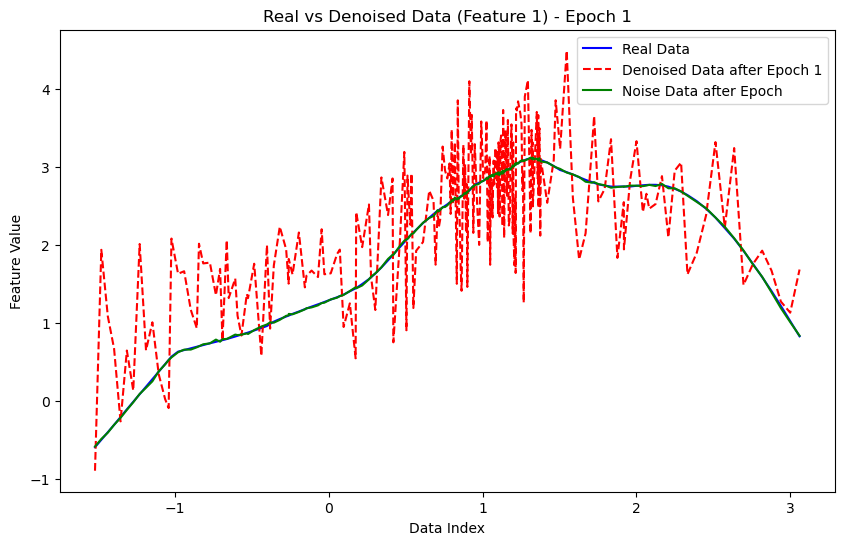

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from spectra_create_dataset import *
from model import TransformerEncoderModel
from utils import DiffusionProcess
from params import (input_dim, n_heads, 
                    n_layers, 
                    output_dim,
                    learning_rate,
                    num_steps,
                    beta_start,
                    beta_end,
                    )


# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df, sorted_wavelengths = use_data()

# Initialize your data and model
data = torch.from_numpy(df).float().to(device)  # Move data to GPU


# Initialize model, optimizer, and diffusion process
model = TransformerEncoderModel(input_dim, n_heads, n_layers, output_dim).to(device)  # Move model to GPU
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
diffusion = DiffusionProcess(num_steps, beta_start, beta_end)

# Store predictions for visualization
predictions = []
noise = []
# Example training loop
epochs = 1000  # Number of epochs
for epoch in range(epochs):
    for step in range(diffusion.steps):
        noisy_data = diffusion.add_noise(data, step)
        # print(model.shape)
        optimizer.zero_grad()
        denoised_data = diffusion.denoise(model, noisy_data, step)

        # Define loss for regression (on GPU)
        loss = nn.MSELoss()(denoised_data, data)
        loss.backward()
        optimizer.step()
        noise.append(noisy_data)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Store denoised data after each epoch for visualization
    with torch.no_grad():
        final_denoised = diffusion.denoise(model, noisy_data, diffusion.steps - 1)  # Get final step prediction
        predictions.append(final_denoised.cpu())  # Move predictions to CPU for visualization

torch.save(model.state_dict(), 'model_weights.pth')
# Convert data to numpy for plotting
real_data_np = data.cpu().detach().numpy()  # Move data to CPU for plotting
predicted_data_np = [pred.cpu().detach().numpy() for pred in predictions]  # Convert to CPU and numpy for plotting
noise_data_np = [noisy.cpu().detach().numpy() for noisy in noise] 
# Visualization
for i in range(epochs):
    if i % 1001 == 0:
        plt.figure(figsize=(10, 6))

        # Plot original data (first feature)
        plt.plot(sorted_wavelengths, real_data_np[:, 0], label='Real Data', color='blue')

        # Plot denoised data (first feature)
        plt.plot(sorted_wavelengths, predicted_data_np[i][:, 0], label=f'Denoised Data after Epoch {i+1}', linestyle='--', color='red')
        
        # Plot the Noise
        plt.plot(sorted_wavelengths, noise_data_np[i][:, 0], label=f'Noise Data after Epoch', linestyle='-', color='green')
        plt.xlabel('Data Index')
        plt.ylabel('Feature Value')
        plt.title(f'Real vs Denoised Data (Feature 1) - Epoch {i+1}')
        plt.legend()
        plt.show()


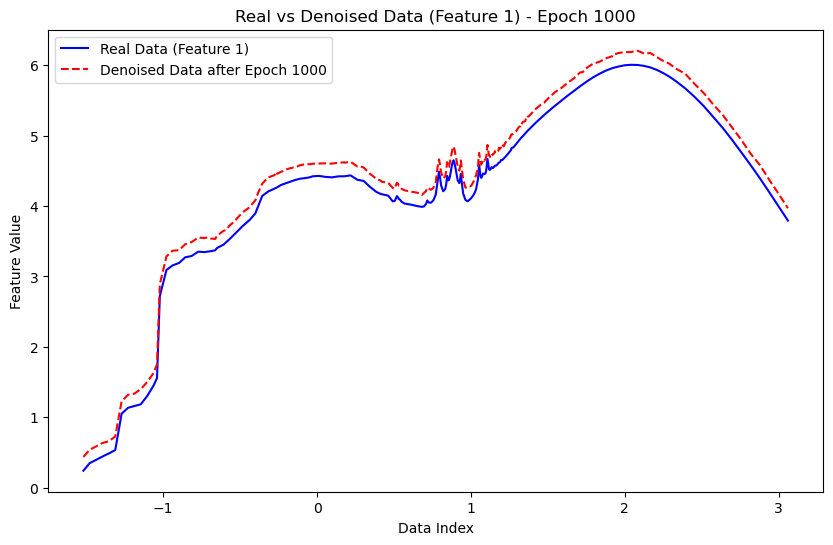

In [33]:
with torch.no_grad():
        final_denoised = diffusion.denoise(model, noisy_data, diffusion.steps - 1)  # Get final step prediction
        predictions.append(final_denoised.cpu())  # Move predictions to CPU for visualization

# Convert data to numpy for plotting
real_data_np = data.cpu().detach().numpy()  # Move data to CPU for plotting
predicted_data_np = [pred.cpu().detach().numpy() for pred in predictions]  # Convert to CPU and numpy for plotting

# Visualization
# for i in range(epochs):
plt.figure(figsize=(10, 6))

# Plot original data (first feature)
plt.plot(sorted_wavelengths, real_data_np[:, 2], label='Real Data (Feature 1)', color='blue')

# Plot denoised data (first feature)
plt.plot(sorted_wavelengths, predicted_data_np[1][:, 2], label=f'Denoised Data after Epoch {i+1}', linestyle='--', color='red')

plt.xlabel('Data Index')
plt.ylabel('Feature Value')
plt.title(f'Real vs Denoised Data (Feature 1) - Epoch {i+1}')
plt.legend()
plt.show()

In [34]:
final_denoised.shape

torch.Size([223, 10])

In [35]:
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data = pd.DataFrame(df)

# Separate the wavelengths and flux values
wavelengths = sorted_wavelengths
flux_values = df

# Normalize the flux values
# scaler = MinMaxScaler()
# flux_values_normalized = scaler.fit_transform(flux_values)

# Convert to PyTorch tensors
flux_tensor = torch.tensor(flux_values, dtype=torch.float32)

print("Data loaded and preprocessed.")
flux_tensor.shape

Data loaded and preprocessed.


torch.Size([223, 10])

In [36]:
import torch.nn as nn

class TransformerGenerator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(TransformerGenerator, self).__init__()
        self.embedding = nn.Linear(latent_dim, 128)  # Embedding layer
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=128, nhead=8), num_layers=16)
        self.fc = nn.Linear(128, output_dim)

    def forward(self, z):
        z = self.embedding(z).unsqueeze(1)  # Add sequence dimension
        z = self.transformer_encoder(z)
        return self.fc(z.squeeze(1))  # Remove sequence dimension

class TransformerDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(TransformerDiscriminator, self).__init__()
        self.embedding = nn.Linear(input_dim, 128)  # Embedding layer
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=128, nhead=8), num_layers=3)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # Add sequence dimension
        x = self.transformer_decoder(x, x)  # Use the same input as target
        return torch.sigmoid(self.fc(x.squeeze(1)))  # Remove sequence dimension

# Define dimensions
input_dim = flux_tensor.shape[1]  # Number of flux columns
latent_dim = 10  # Dimension of the random noise

# Instantiate the models
generator = TransformerGenerator(latent_dim, input_dim).to(device)
discriminator = TransformerDiscriminator(input_dim).to(device)

print("Generator and Discriminator defined.")



Generator and Discriminator defined.


In [37]:
from tqdm import tqdm

In [38]:
import matplotlib.pyplot as plt

# Hyperparameters
num_epochs = 10000
batch_size = 32
learning_rate = 0.0001

# Loss functions and optimizers
criterion = nn.MSELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

# Lists to store losses
losses_G = []
losses_D = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    for i in range(0, len(flux_tensor), batch_size):
        # Get real data
        real_data = flux_tensor[i:i + batch_size]
        batch_size_real = real_data.size(0)

        # Create labels
        real_labels = torch.ones(batch_size_real, 1).to(device)
        fake_labels = torch.zeros(batch_size_real, 1).to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        outputs = discriminator(real_data.to(device)).to(device)
        loss_D_real = criterion(outputs, real_labels)

        # Generate fake data
        noise = torch.randn(batch_size_real, latent_dim).to(device)
        fake_data = generator(noise)
        outputs = discriminator(fake_data.detach())
        loss_D_fake = criterion(outputs, fake_labels)

        # Backpropagation for Discriminator
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        outputs = discriminator(fake_data).to(device)
        loss_G = criterion(outputs, real_labels)

        # Backpropagation for Generator
        loss_G.backward()
        optimizer_G.step()

        # Store losses
        losses_G.append(loss_G.item())
        losses_D.append(loss_D.item())

    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}')

# Visualization of losses
plt.figure(figsize=(12, 5))
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_D, label='Discriminator Loss')
plt.title('Losses during Training')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()




  0%|          | 1/10000 [00:00<1:57:19,  1.42it/s]

Epoch [0/10000], Loss D: 0.5509, Loss G: 0.1990


  1%|          | 61/10000 [00:39<1:47:44,  1.54it/s]


KeyboardInterrupt: 

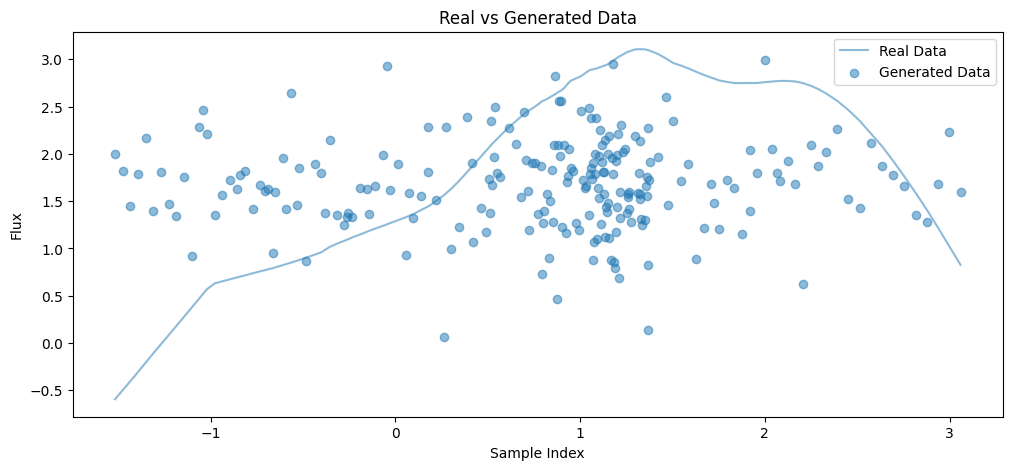

In [14]:
# Visualize generated data
with torch.no_grad():
    noise = torch.randn(223, latent_dim).to(device)
    generated_data = generator(noise).cpu().numpy()

# Plot real vs generated data
plt.figure(figsize=(12, 5))
plt.plot(sorted_wavelengths,df[:223,0], label='Real Data', alpha=0.5)
plt.scatter(sorted_wavelengths,generated_data[:223,0], label='Generated Data', alpha=0.5)
plt.title('Real vs Generated Data')
plt.xlabel('Sample Index')
plt.ylabel('Flux')
plt.legend()
plt.show()